# Installs

In [ ]:
import torch;
print(torch.__version__)
print(torch.version.cuda)
print(torch.cuda.is_available())

2.5.1+cu121
12.1
False


In [ ]:
!pip install pytorch-lightning
!pip install torch-geometric
!pip install pyg_lib torch_scatter torch_sparse torch_cluster torch_spline_conv -f https://data.pyg.org/whl/torch-2.1.0+cu118.html
!pip install jax
!pip install --upgrade jax jaxlib==0.4.20+cpu -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html
!pip install tensorcircuit
!pip install qiskit
!pip install matplotlib
!pip install pylatexenc
!pip install tabulate
!pip install kmapper
!pip install qutip

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 926.4/926.4 kB 30.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 15.3 MB/s eta 0:00:00
Looking in links: https://data.pyg.org/whl/torch-2.1.0+cu118.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 19.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 16.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 31.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 887.8/887.8 kB 20.4 MB/s eta 0:00:00
Looking in links: https://storage.googleapis.com/jax-releases/jax_cuda_releases.html
ERROR: Ignored the following yanked versions: 0.4.32
ERROR: Could not find a version that satisfies the requirement jaxlib==0.4.20

In [ ]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1' # Comment this to use gpu

In [ ]:
import torch_geometric
import torch_geometric.nn as geom_nn
import torch_geometric.data as geom_data
import torch_geometric.transforms as T

import torch
import torch.nn as nn
import qutip
from qutip import Bloch
import matplotlib
from matplotlib import pyplot as plt
import sklearn as skl
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, auc

import pytorch_lightning as pl
from pytorch_lightning.callbacks import LearningRateMonitor, ModelSummary
from pytorch_lightning.callbacks import Callback

from pytorch_lightning.loggers import WandbLogger

import jax
import jax.numpy as jnp
import tensorcircuit as tc

import numpy as np
import pandas as pd
import kmapper as km
import networkx as nx
from copy import copy

import warnings
warnings.filterwarnings('ignore')

torch.set_float32_matmul_precision("medium")
K = tc.set_backend("jax")
print(tc.__version__)

/usr/local/lib/python3.10/dist-packages/torch_geometric/typing.py:68: UserWarning: An issue occurred while importing 'pyg-lib'. Disabling its usage. Stacktrace: libcudart.so.11.0: cannot open shared object file: No such file or directory
  warnings.warn(f"An issue occurred while importing 'pyg-lib'. "
/usr/local/lib/python3.10/dist-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: /usr/local/lib/python3.10/dist-packages/torch_scatter/_version_cuda.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
/usr/local/lib/python3.10/dist-packages/torch_geometric/typing.py:97: UserWarning: An issue occurred while importing 'torch-cluster'. Disabling its usage. Stacktrace: /usr/local/lib/python3.10/dist-packages/torch_cluster/_version_cuda.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev
  warnings.warn(f"An issue occurred while importin

0.12.0


In [ ]:
jax.devices()

[CpuDevice(id=0)]

In [ ]:
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print(device)

cpu


In [ ]:
import os
import torch
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, ModelSummary, LearningRateMonitor
from time import time

In [ ]:
import torch
import torch.nn.functional as F
import torch_geometric
from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import GCNConv
import pytorch_lightning as pl
from torch_geometric.nn import global_mean_pool
from torchmetrics.classification import Accuracy

# QUANTUM MODEL


In [ ]:
def get_circ(nqubits, nlayers, x, weights):

    c = tc.Circuit(nqubits)
    for i in range(nqubits):
        c.rx(i, theta=x[i])
    for j in range(nlayers):
        for i in range(nqubits - 1):
            c.cnot(i, i + 1)
        for i in range(nqubits):
            c.rx(i, theta=weights[2 * j, i])
            c.ry(i, theta=weights[2 * j + 1, i])
    return c

# test = None;

def circuit_wrapper(nqubits, nlayers):
    # global test
    # We define the quantum function,
    # note how this function is running on jax
    def qpred(x, weights):
        # global test
        # print(x.shape, "In wrapper", x)
        circuit = get_circ(nqubits, nlayers, x, weights)
        # print(circuit)
        # test = circuit
        # print(K.real(jnp.array(circuit.expectation_ps(z=[1]))))
        return K.real(jnp.array([circuit.expectation_ps(z=[i]) for i in range(nqubits)]))

    # `qpred_vmap` is a jax function with vectorization capacity
    qpred_vmap = K.vmap(qpred, vectorized_argnums=0)

    # Wrap the function into pytorch form but with jax speed!
    qpred_batch = tc.interfaces.torch_interface(qpred_vmap, jit=True)

    return qpred_batch

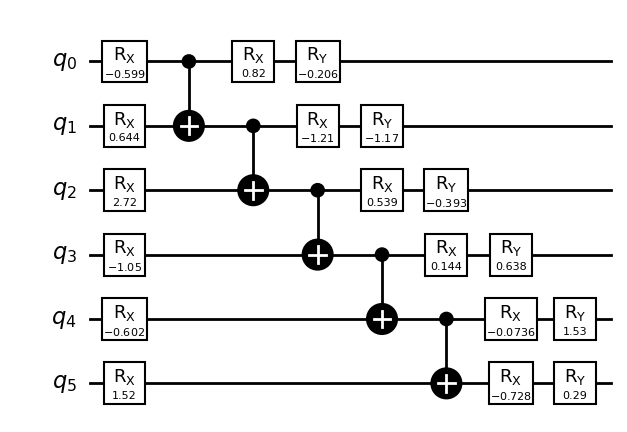

In [ ]:
# Test the AD capacity of the PyTorch function
nqubits = 6
nlayers = 1
w = torch.randn([2 * nlayers, nqubits])
dummy_x = torch.randn([3, nqubits])

fig = get_circ(nqubits, nlayers, dummy_x[0], w).draw(output='mpl', style="bw", fold=0)
fig

In [ ]:
qpred_batch = circuit_wrapper(nqubits, nlayers)

In [ ]:
w.requires_grad_()
with torch.set_grad_enabled(True):
    print(dummy_x.shape, dummy_x)
    yps = qpred_batch(dummy_x, w)
    loss = torch.sum(yps)
    loss.backward()
print(w.grad, yps)

torch.Size([3, 6]) tensor([[-5.9894e-01,  6.4437e-01,  2.7200e+00, -1.0463e+00, -6.0216e-01,
          1.5217e+00],
        [ 3.1563e-01,  1.7106e-01, -9.4038e-01,  9.9146e-04,  1.6244e+00,
         -2.2127e-01],
        [-2.3093e-01,  5.0592e-01, -7.7704e-01, -2.1441e+00,  1.5607e+00,
          8.3886e-01]])
tensor([[-1.9681e+00,  8.8558e-01, -2.6414e-01,  9.0950e-03, -8.7474e-04,
          1.4725e-01],
        [ 3.8322e-01,  7.9831e-01,  1.8313e-01,  4.6435e-02,  2.8053e-01,
          5.5710e-02]]) tensor([[ 5.5164e-01,  9.0258e-02, -4.7747e-01, -2.3990e-01, -1.0470e-02,
         -1.6698e-01],
        [ 6.3491e-01,  1.2804e-01,  4.3760e-01,  4.3910e-01, -1.2458e-03,
         -1.6517e-02],
        [ 6.5017e-01,  1.1639e-01,  4.8113e-01, -2.6187e-01, -1.4022e-04,
         -3.1703e-03]], grad_fn=<FunBackward>)


In [ ]:
class QuantumNet(nn.Module):
    def __init__(self, nqubits, nlayers):
        super().__init__()
        self.q_weights = torch.nn.Parameter(torch.randn([2 * nlayers, nqubits]))
        self.qpred_batch = circuit_wrapper(nqubits, nlayers)

        self.nqubits = nqubits
        self.nlayers = nlayers

    def forward(self, inputs):
#         print("Inside quantum net", inputs.shape)
        ypred = self.qpred_batch(inputs, self.q_weights)
#         print("output of qpred", ypred.shape)
        return ypred

In [ ]:
net = QuantumNet(6, 2)
out = net(dummy_x)
print(out)
print(out.shape)

tensor([[ 0.0477, -0.1072,  0.0567,  0.1425,  0.1018,  0.0412],
        [ 0.0696,  0.0434,  0.0590, -0.0085, -0.0470, -0.0402],
        [ 0.0609,  0.0049, -0.0527,  0.0130,  0.0373,  0.0057]],
       grad_fn=<FunBackward>)
torch.Size([3, 6])


In [ ]:
class QGCNConv(geom_nn.GCNConv):
    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        improved: bool = False,
        cached: bool = False,
        add_self_loops: bool = True,
        normalize: bool = True,
        bias: bool = True,
        nlayers = 2,
        **kwargs,
    ):
        super().__init__(in_channels,
                        out_channels,
                        improved,
                        cached,
                        add_self_loops,
                        normalize,
                        bias,
                        **kwargs)
        self.lin = QuantumNet(in_channels, nlayers)

In [ ]:
gnn_layer_by_name = {
    "QGCN": QGCNConv,
    "GCN" : geom_nn.GCNConv,
    "GAT": geom_nn.GATConv,
    "GraphConv": geom_nn.GraphConv,
    "SAGE": geom_nn.SAGEConv
}

#### This part is testing the QGCNonv model

In [ ]:
from torchmetrics.classification import Accuracy

class GraphModel(pl.LightningModule):
    def __init__(self, in_channels, hidden_channels, out_channels, nlayers=1):
        super().__init__()
        self.conv1 = QGCNConv(in_channels, hidden_channels, nlayers)
        self.conv2 = QGCNConv(hidden_channels, out_channels, nlayers)
        self.lin = torch.nn.Linear(out_channels, 2)  # For binary classification
        self.train_accuracy = Accuracy(task="binary")
        self.val_accuracy = Accuracy(task="binary")

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))
        x = global_mean_pool(x, batch)
        return self.lin(x)

    def training_step(self, batch, batch_idx):
        out = self(batch)
        loss = F.cross_entropy(out, batch.y)
        preds = torch.argmax(out, dim=1)
        acc = self.train_accuracy(preds, batch.y)
        self.log("train_loss", loss, prog_bar=True, on_step=True, on_epoch=True)
        self.log("train_acc", acc, prog_bar=True, on_step=True, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx):
        out = self(batch)
        loss = F.cross_entropy(out, batch.y)
        preds = torch.argmax(out, dim=1)
        acc = self.val_accuracy(preds, batch.y)
        self.log("val_loss", loss, prog_bar=True, on_epoch=True)
        self.log("val_acc", acc, prog_bar=True, on_epoch=True)

    def on_validation_epoch_end(self):
        # Called at the end of each validation epoch
        avg_val_acc = self.val_accuracy.compute()
        self.log("epoch_val_acc", avg_val_acc, prog_bar=True)
        self.val_accuracy.reset()  # Reset for the next epoch

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.01)


In [ ]:
# Create a simple synthetic graph dataset
def create_synthetic_data():
    edge_index = torch.tensor([[0, 1, 1, 2], [1, 0, 2, 1]], dtype=torch.long)  # Simple graph edges
    x = torch.rand((3, 8), dtype=torch.float)  # Node features (3 nodes, 5 features per node)
    y = torch.tensor([0], dtype=torch.long)    # Graph label (binary classification)
    data = Data(x=x, edge_index=edge_index, y=y)
    return [data] * 10  # Return a list of the same graph data to form a small dataset

In [ ]:
# Create data loaders
train_dataset = create_synthetic_data()
train_loader = DataLoader(train_dataset, batch_size=2)

# Initialize model, trainer, and start training
model = GraphModel(in_channels=8, hidden_channels=8, out_channels=8, nlayers=1)
trainer = pl.Trainer(max_epochs=5, accelerator="cpu", enable_progress_bar=True)
trainer.fit(model, train_loader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name           | Type           | Params | Mode 
----------------------------------------------------------
0 | conv1          | QGCNConv       | 24     | train
1 | conv2          | QGCNConv       | 24     | train
2 | lin            | Linear         | 18     | train
3 | train_accuracy | BinaryAccuracy | 0      | train
4 | val_accuracy   | BinaryAccuracy | 0      | train
----------------------------------------------------------
66        Trainable params
0         Non-trainable params
66        Total params
0.000     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


# Finance Dataset

#### Loading

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Install the Kaggle library
!pip install kaggle

# Upload kaggle.json file
from google.colab import files
files.upload()  # This will prompt you to upload kaggle.json

# Make a directory for Kaggle and move the file there
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Now you can download the dataset
!kaggle datasets download -d mlg-ulb/creditcardfraud -p /content/datasets --unzip

print("Dataset downloaded to: /content/datasets")

KeyboardInterrupt: 

In [ ]:
finance_df=pd.read_csv("/content/datasets/creditcard.csv",delimiter=',')

In [ ]:
finance_df.describe()

In [ ]:
finance_df

#### Processing

In [ ]:
def get_graph(nx_graph, data, row):
  nodes = list(nx_graph.nodes());
  edges = list(nx_graph.edges());
  feature = [];
  for n in nodes:
    mem = np.array(nx_graph._node[n]['membership']);
    id = np.zeros(28, dtype = int);
    id[mem] = 1;
    ft = data * id;
    feature.append(ft)
  edges = np.array(list(map(lambda x: (nodes.index(x[0]), nodes.index(x[1])),edges)))
  nodes = np.array(list(map(lambda x: nodes.index(x),nodes)))
  return nodes, edges.transpose(), np.array(feature);

In [ ]:
fraud_id = finance_df.Class[finance_df.Class.eq(1)].index
nofraud_id = finance_df.Class[finance_df.Class.eq(0)].sample(len(fraud_id)*3).index

df_reduced = finance_df.loc[fraud_id.union(nofraud_id)].sample(frac = 1).reset_index( drop = True);

In [ ]:
print(fraud_id.shape, nofraud_id.shape)

In [ ]:
df_reduced.shape

In [ ]:
mp = km.KeplerMapper()
# Initializes KeplerMapper to create topological data visualizations.

transform = T.Compose([T.Pad(max_num_nodes=16, max_num_edges=5, mask_pad_value=True)])
# Defines a transformation pipeline to pad node and edge counts to fixed sizes.

def get_data(df):
    data_list = []
    # List to store processed graph data objects.

    nodes_dist, edges_dist = [], []
    # Lists to track node and edge distributions for each graph.

    graphs = []
    # List to store graph structures for further use.

    for i in range(df.shape[0]):
        data_row = df.loc[i, df.columns[1:29]].to_numpy()
        # Extracts specific columns as features for each row.

        data = data_row.transpose()
        # Transposes features to match the input shape for KeplerMapper.

        Y = df.iloc[i, 30]
        # Extracts target label for the row.

        amt = df.iloc[i, 29]
        # Extracts the 'amount' feature for each row.

        time = df.iloc[i, 0]
        # Extracts the 'time' feature for each row.

        amt = np.repeat(amt, data.shape[0])
        # Repeats the amount value for all data points in the row.

        time = np.repeat(time, data.shape[0])
        # Repeats the time value for all data points in the row.

        data = np.stack((data, amt, time), axis=1)
        # Stacks the features, amount, and time into a single array.

        lens = mp.project(data)
        # Projects data into a lower-dimensional lens for mapping.

        graph = mp.map(X=data, lens=lens)
        # Creates a topological graph representation of the data.

        nx_graph = km.adapter.to_nx(graph)
        # Converts the mapper's graph structure into a NetworkX graph.

        nodes, edges, features = get_graph(nx_graph, data_row, i)
        # Extracts nodes, edges, and features from the graph.

        nodes_dist.append(len(nodes))
        # Appends the number of nodes in the graph.

        edges_dist.append(0 if len(edges) == 0 else edges.shape[1])
        # Appends the number of edges (or zero if no edges exist).

        data_list.append(
            geom_data.Data(
                x=torch.tensor(features, dtype=torch.float),
                # Stores node features as a PyTorch tensor.
                edge_index=torch.tensor(edges, dtype=torch.int64),
                # Stores edge indices as a PyTorch tensor.
                y=torch.tensor(Y)
                # Stores the target label as a PyTorch tensor.
            )
        )

        graphs.append((nx_graph, nodes, edges, features))
        # Stores graph structure and associated details.

    return data_list, graphs
    # Returns the processed data list and graph structures.

data_list, graphs = get_data(df_reduced)
# Calls the function with the dataset.


In [ ]:
batch_s = 64;
split = int(len(data_list) * 0.75);
graph_train_loader = geom_data.DataLoader(data_list[:split], batch_size=batch_s,shuffle=True)
graph_val_loader = geom_data.DataLoader(data_list[split:], batch_size=batch_s,shuffle=False)
graph_test_loader = geom_data.DataLoader(data_list[split:], batch_size=batch_s,shuffle=False)

In [ ]:
batch = next(iter(graph_test_loader))
print("Batch:", batch)
print("Labels:", batch.y)
print("Batch indices:", batch.batch)
print("Batch ptr:", batch.ptr)

Batch: DataBatch(x=[126, 28], edge_index=[2, 46], y=[32], batch=[126], ptr=[33])
Labels: tensor([0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0,
        1, 0, 0, 1, 0, 0, 0, 0])
Batch indices: tensor([ 0,  0,  0,  0,  0,  1,  1,  1,  2,  2,  2,  2,  2,  3,  3,  4,  4,  4,
         4,  4,  4,  5,  5,  5,  6,  6,  6,  7,  7,  7,  8,  8,  8,  8,  8,  9,
         9,  9,  9, 10, 10, 10, 10, 11, 11, 11, 12, 13, 13, 13, 13, 13, 14, 14,
        14, 14, 15, 15, 15, 16, 16, 16, 16, 16, 17, 17, 17, 17, 17, 18, 18, 18,
        18, 19, 19, 19, 19, 20, 20, 20, 21, 21, 21, 21, 21, 22, 22, 22, 22, 23,
        23, 23, 23, 23, 24, 24, 24, 24, 25, 25, 25, 26, 26, 26, 26, 26, 27, 27,
        28, 28, 28, 28, 29, 29, 29, 29, 30, 30, 30, 30, 30, 31, 31, 31, 31, 31])
Batch ptr: tensor([  0,   5,   8,  13,  15,  21,  24,  27,  30,  35,  39,  43,  46,  47,
         52,  56,  59,  64,  69,  73,  77,  80,  85,  89,  94,  98, 101, 106,
        108, 112, 116, 121, 126])


#Models

In [ ]:
import torch
import torch.nn as nn
import torch_geometric.nn as geom_nn  # Assumes usage of PyTorch Geometric

class GraphGNNModel(nn.Module):
    def __init__(self, c_in, c_hidden, c_out, num_layers=2, layer_name="QGCN", dp_rate=0.1, dp_rate_linear=0.5, **kwargs):
        """
        Inputs:
            c_in - Dimension of input features
            c_hidden - Dimension of hidden features
            c_out - Dimension of output features (usually number of classes)
            num_layers - Number of "hidden" graph layers
            layer_name - String of the graph layer to use
            dp_rate - Dropout rate applied throughout the network
            dp_rate_linear - Dropout rate before the final linear layer
            kwargs - Additional arguments for the graph layers (e.g. number of heads for GAT)
        """
        super().__init__()
        # Embedding layer
        self.embed = nn.Linear(c_in, c_hidden)
        self.dropout_embed = nn.Dropout(dp_rate)

        # GNN layers
        gnn_layer = gnn_layer_by_name[layer_name]
        self.gnn_layers = nn.ModuleList()
        self.dropouts = nn.ModuleList()
        in_channels = c_hidden
        for _ in range(num_layers - 1):
            self.gnn_layers.append(
                gnn_layer(in_channels=in_channels, out_channels=c_hidden, nlayers=2, bias=False, **kwargs)
            )
            self.dropouts.append(nn.Dropout(dp_rate))
            in_channels = c_hidden
        self.gnn_layers.append(
            gnn_layer(in_channels=in_channels, out_channels=c_hidden, nlayers=2, bias=False, **kwargs)
        )
        self.dropouts.append(nn.Dropout(dp_rate))

        # Final prediction head
        self.head = nn.Sequential(
            nn.Dropout(dp_rate_linear),
            nn.Linear(c_hidden, c_out)
        )

    def forward(self, x, edge_index, batch_idx):
        """
        Inputs:
            x - Input features per node
            edge_index - List of vertex index pairs representing the edges in the graph
                         (PyTorch geometric notation)
            batch_idx - Index of batch element for each node
        """
        # Embedding step
        x = self.embed(x)
        x = self.dropout_embed(x)

        # GNN processing
        for gnn_layer, dropout in zip(self.gnn_layers, self.dropouts):
            if isinstance(gnn_layer, geom_nn.MessagePassing):
                x = gnn_layer(x, edge_index)
            else:
                x = gnn_layer(x)
            x = dropout(x)

        # Graph-level pooling
        x = geom_nn.global_mean_pool(x, batch_idx)

        # Final prediction
        x = self.head(x)

        return x


In [ ]:
def get_prob(probs):
  ex = probs.exp();
  return ex / ex.sum();

class GraphLevelGNN(pl.LightningModule):

    def __init__(self, **model_kwargs):
        super().__init__()
        # Saving hyperparameters
        self.save_hyperparameters()
        self.model = GraphGNNModel(**model_kwargs).to(device);
        self.loss_module = nn.BCEWithLogitsLoss() if self.hparams.c_out == 1 else nn.CrossEntropyLoss()
        self.one_cycle_max_lr = 1e-1
        self.one_cycle_total_steps = 100
        self.test_prob = [];
        self.test_actual = [];

    def forward(self, tdata, mode="train"):
        data = tdata

        x, edge_index, batch_idx = data.x, data.edge_index, data.batch
        x = self.model(x, edge_index, batch_idx)
        x = x.squeeze(dim=-1)

        if self.hparams.c_out == 1:
            preds = (x > 0).float() # Positive means fraud
            data.y = data.y.float()
        else:
            preds = x.argmax(dim=-1)

        loss = self.loss_module(x, data.y)
        acc = (preds == data.y).sum().float() / preds.shape[0]

        # print("After model", x, preds)

        target = data.y.cpu().numpy();
        predicton = preds.cpu().numpy();

        cm = confusion_matrix(target,predicton);
        ac = accuracy_score(target,predicton);
        ps = precision_score(target,predicton);
        rs = recall_score(target,predicton);
        fs = f1_score(target,predicton);

        # print("Values", cm)
        if mode == "test":
          return loss, acc, cm, ac, ps, rs, fs, target, get_prob(x).cpu().numpy();
        else :
          return loss, acc, cm, ac, ps, rs, fs;

    def configure_optimizers(self):
        # High lr because of small dataset and small model
        optimizer = torch.optim.AdamW(self.parameters(), lr=1e-2, weight_decay=0.001)
        return optimizer
        scheduler = torch.optim.lr_scheduler.OneCycleLR(
            optimizer=optimizer, max_lr=self.one_cycle_max_lr, total_steps=self.one_cycle_total_steps
        )
        return {"optimizer": optimizer, "lr_scheduler": scheduler, "monitor": "val_loss"}

    def training_step(self, batch, batch_idx):
        loss, acc, cm, ac, ps, rs, fs = self.forward(batch, mode="train")
        self.log('train_loss', loss, on_step=False, on_epoch=True, prog_bar=True, batch_size=batch_s)
        self.log('train_acc', acc, on_step=False, on_epoch=True, prog_bar=True, batch_size=batch_s)
        # print(loss)
        # print("Training called for: ", batch_idx);
        return loss

    def validation_step(self, batch, batch_idx):
        loss, acc, cm, ac, ps, rs, fs = self.forward(batch, mode="val")
        self.log('val_acc', acc, prog_bar=True, batch_size=batch_s)
        self.log('val_loss', loss, prog_bar=True, batch_size=batch_s)
        return loss

    def test_step(self, batch, batch_idx):
        loss, acc, cm, ac, ps, rs, fs, y, x  = self.forward(batch, mode="test")
        self.log('test_acc', acc, on_step=False, on_epoch=True, batch_size=batch_s)
        # self.log('test_cm', cm.tolist(), on_step=False, on_epoch=True, batch_size=batch_s)
        self.log('test_ac', ac, on_step=False, on_epoch=True, batch_size=batch_s)
        self.log('test_ps', ps, on_step=False, on_epoch=True, batch_size=batch_s)
        self.log('test_rs', rs, on_step=False, on_epoch=True, batch_size=batch_s)
        self.log('test_fs', fs, on_step=False, on_epoch=True, batch_size=batch_s)
        self.test_prob.extend(x.tolist());
        self.test_actual.extend(y.tolist());

# Trainer

In [ ]:
from time import time

CHECKPOINT_PATH = "/content/checkpoints"

class MetricTracker(Callback):

  def __init__(self):
    self.collection = []

  def on_train_epoch_end(self, trainer, module):
    metric = trainer.logged_metrics.copy();
    self.collection.append(metric)
    # print("train trainer end", trainer.logged_metrics)

def disp_loss(trainer):
  # print(trainer.callbacks[2].collection)

  train_loss = list(map(lambda x: x['train_loss'].item(),
                        trainer.callbacks[2].collection));
  val_loss = list(map(lambda x: x['val_loss'].item(),
                        trainer.callbacks[2].collection));

  # print(range(len(train_loss)), train_loss)
  fig = plt.figure();
  plt.plot(range(len(train_loss)), train_loss, color = 'b', label = 'Training Loss');
  plt.plot(range(len(val_loss)),val_loss, color = 'r', label = 'Validation Loss');

  plt.xlabel("Epochs")
  plt.ylabel("Loss")
  # Adding legend, which helps us recognize the curve according to it's color
  plt.legend()
  plt.show();
  fig.savefig('Quantum_Loss.pdf', format='pdf', dpi=300, bbox_inches='tight');


In [ ]:
os.environ["XLA_FLAGS"] = "--xla_gpu_cuda_data_dir=/usr/local/cuda"
os.environ["XLA_PTX_ASM_COMPILATION"] = "0"

!rm -rf /tmp/*


def train_graph_classifier(model_name, num_epochs=10, **model_kwargs):
    pl.seed_everything(42)

    # Setup callbacks without specifying a root directory for checkpointing
    callbacks = [
        ModelSummary(max_depth=4),
        LearningRateMonitor(logging_interval='epoch'),
        ModelCheckpoint(monitor="val_loss", save_top_k=1, mode="min"),  # Save best model by validation loss
        MetricTracker()  # Assumes MetricTracker is defined elsewhere
    ]

    # Initialize the trainer
    trainer = pl.Trainer(
        callbacks=callbacks,
        accelerator="gpu" if torch.cuda.is_available() else "cpu",
        devices=1,
        log_every_n_steps=2,
        max_epochs=num_epochs,
        enable_progress_bar=True
    )

    #########################    MODEL   #############################
    model = GraphLevelGNN(c_in=28, c_out=1, **model_kwargs).to(device)
    ##################################################################


    s = time()
    trainer.fit(model, graph_train_loader, graph_val_loader)
    e = time()

    # Display loss progression
    disp_loss(trainer)

    # Test best model on validation and test sets
    test_result = trainer.test(model, graph_test_loader, verbose=False)
    test_y, test_prob = model.test_actual, model.test_prob
    train_result = trainer.test(model, graph_train_loader, verbose=False)

    # Collect test and train results for specific metrics
    result = [
        {"test": test_result[0]['test_acc'], "train": train_result[0]['test_acc']},
        {"test": test_result[0]['test_ac'], "train": train_result[0]['test_ac']},
        {"test": test_result[0]['test_ps'], "train": train_result[0]['test_ps']},
        {"test": test_result[0]['test_rs'], "train": train_result[0]['test_rs']},
        {"test": test_result[0]['test_fs'], "train": train_result[0]['test_fs']}
    ]

    return model, result, (e - s) / num_epochs, test_y, test_prob



rm: cannot remove '/tmp/colab_runtime.sock': Device or resource busy


# Run

In [ ]:
import os
os.environ["XLA_FLAGS"] = "--xla_gpu_cuda_data_dir=/usr/local/cuda"
os.environ["XLA_PTX_ASM_COMPILATION"] = "0"


In [ ]:
!free -h

               total        used        free      shared  buff/cache   available
Mem:            12Gi       2.2Gi       3.2Gi       2.0Mi       7.3Gi        10Gi
Swap:             0B          0B          0B


INFO:lightning_fabric.utilities.seed:Seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                           | Type              | Params | Mode 
------------------------------------------------------------------------------
0  | model                          | GraphGNNModel     | 229    | train
1  | model.embed                    | Linear            | 174    | train
2  | model.dropout_embed            | Dropout           | 0      | train
3  | model.gnn_layers               | ModuleList        | 48     | tr

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=50` reached.


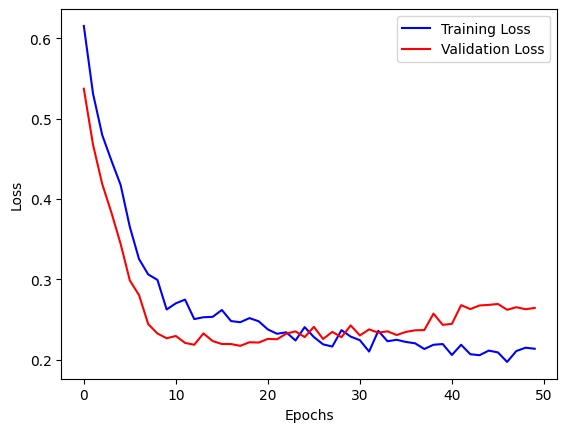

Testing: |          | 0/? [00:00<?, ?it/s]

Testing: |          | 0/? [00:00<?, ?it/s]

In [ ]:
num_epochs = 50
model, result, avg_epoch_time, test_y, test_prob = train_graph_classifier(model_name="QGCN",
                                       c_hidden=6,
                                       layer_name="QGCN",
                                       num_layers=2,
                                       num_epochs=num_epochs,
                                       dp_rate_linear=0.5,
                                       dp_rate=0.0)


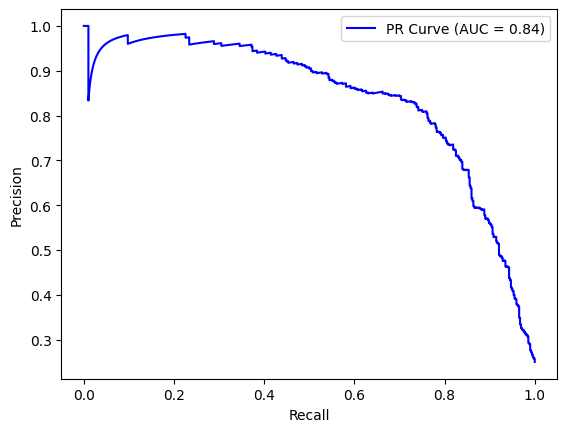

In [ ]:
# Precision - recall curve
precision, recall, thresholds = precision_recall_curve(test_y, test_prob)
auc_pr = auc(recall, precision)
fig = plt.figure();
plt.plot(recall, precision, color = 'b', label = f'PR Curve (AUC = {auc_pr:2.2f})');
plt.xlabel("Recall")
plt.ylabel("Precision")
# Adding legend, which helps us recognize the curve according to it's color
plt.legend(loc = 'upper right')
plt.show();
fig.savefig('Quantum_PR.pdf', format='pdf', dpi=300, bbox_inches='tight');

In [ ]:
# # Roc Curve
# fpr, tpr, thresholds = roc_curve(y, probs)
# auc = roc_auc_score(y, probs)
# print('AUC: %.3f' % auc)


In [ ]:
result

[{'test': 0.916015625, 'train': 0.9507978558540344},
 {'test': 0.916015625, 'train': 0.9507978558540344},
 {'test': 0.8584033250808716, 'train': 0.9484941363334656},
 {'test': 0.8032422661781311, 'train': 0.8259888291358948},
 {'test': 0.8194121718406677, 'train': 0.8793005347251892}]

In [ ]:
print(f"Train performance accuracy: {100.0*result[0]['train']:4.2f}%")
print(f"Test performance accuracy:  {100.0*result[0]['test']:4.2f}%")

print(f"Train performance Precision: {100.0*result[2]['train']:4.2f}%")
print(f"Test performance Precision:  {100.0*result[2]['test']:4.2f}%")

print(f"Train performance Recall: {100.0*result[3]['train']:4.2f}%")
print(f"Test performance Recall:  {100.0*result[3]['test']:4.2f}%")

print(f"Train performance f1 Score: {result[4]['train']:4.2f}")
print(f"Test performance f1 Score:  {result[4]['test']:4.2f}")


print(f"time: {avg_epoch_time*num_epochs}")
print(f"Avg time per epoch: {avg_epoch_time}")

Train performance accuracy: 95.08%
Test performance accuracy:  91.60%
Train performance Precision: 94.85%
Test performance Precision:  85.84%
Train performance Recall: 82.60%
Test performance Recall:  80.32%
Train performance f1 Score: 0.88
Test performance f1 Score:  0.82
time: 1027.066285610199
Avg time per epoch: 20.541325712203978


# Results

25 epochs only

| num qubits  | layers | Accuracy (%) | Precision (%) | Recall (%) | F1Score|
|---|---|---|---|---|---|
| 6  | 1 | 94.5 | 96.1 | 79.5 | .86|
| 16  | 1 | 92.06 | 86.5 | 77.3 | .81
| 6  | 2 | 91.5 | 93.3 | 65.6 | .76 |
| 16  | 2 | 89.2 | 86.6 | 72 | .77 |

Hidden dimension = 6, number of layers = 1

GCN: {'test_acc': 0.91796875, 'test_ac': 0.91796875, 'test_ps': 0.9380208333333333, 'test_rs': 0.7529853826728827, 'test_fs': 0.8231823723886081}


GAT: {'test_acc': 0.923828125, 'test_ac': 0.923828125, 'test_ps': 0.9519097222222223, 'test_rs': 0.7634020493395494, 'test_fs': 0.8384800863705327}


GraphConv: {'test_acc': 0.9088541865348816, 'test_ac': 0.9088541666666666, 'test_ps': 0.8939732142857144, 'test_rs': 0.7590617715617716, 'test_fs': 0.8080692234761172}

SAGEConv: {'test_acc': 0.9186198115348816, 'test_ac': 0.9186197916666666, 'test_ps': 0.867013888888889, 'test_rs': 0.7321856962481962, 'test_fs': 0.7766455256344964}